In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")

In [2]:
import copy
import torch

from utils.visualization import display_image_pair
from utils.model import read_model_config, load_model
from utils.dataset import read_dataset_config, load_dataset, Preprocessor
from utils.correspondence import compute_pck_img, compute_pck_bbox, flip_points, rescale_points

/export/home/ra63des/miniconda3/envs/distilldift/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
model_name = 'diff_add'
dataset_config = '../dataset_config.yaml'
model_config = '../eval_config.yaml'
device_type = 'cuda'
pck_threshold = 0.1

In [4]:
# Load model config
model_config = read_model_config(model_config)[model_name]

# Get model parameters
image_size = model_config.get('image_size', (512, 512))
grad_enabled = model_config.get('grad_enabled', False)
rescale_data = model_config.get('rescale_data', False)
image_range = model_config.get('image_range', (-1, 1))

# Load model
model = load_model(model_name, model_config, device_type)

# Move model to device
device = torch.device(device_type)
model.to(device)

# Load dataset config
dataset_config = read_dataset_config(dataset_config)

# Define preprocessor
preprocess = Preprocessor(image_size, image_range=image_range, rescale_data=rescale_data)

Keyword arguments {'safety_checker': None} are not expected by StableDiffusionXLPipeline and will be ignored.
Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00, 14.18it/s]


Evaluating dataset: SPair-71k


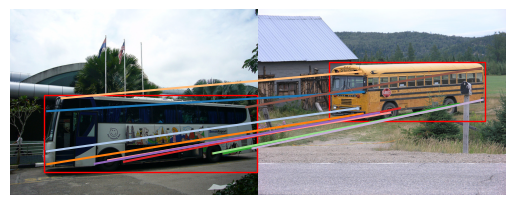

In [7]:
# Evaluate
dataset_name = list(dataset_config.keys())[0]
print(f"Evaluating dataset: {dataset_name}")
config = dataset_config[dataset_name]
dataset = load_dataset(dataset_name, config)

# Take first sample
unprocessed_sample = dataset[0]

# Use only 1 keypoint for Hedlin et al. because of time constraints
if model_name == 'hedlin':
    rand_i = torch.randint(0, unprocessed_sample['source_points'].shape[0], (1,)).item()
    unprocessed_sample['source_points'] = unprocessed_sample['source_points'][rand_i, :].unsqueeze(0)
    unprocessed_sample['target_points'] = unprocessed_sample['target_points'][rand_i, :].unsqueeze(0)

# Visualize sample
display_image_pair(unprocessed_sample, show_bbox=True)

# Preprocess sample
sample = preprocess(copy.deepcopy(unprocessed_sample))
sample['source_image'] = sample['source_image'].unsqueeze(0)
sample['target_image'] = sample['target_image'].unsqueeze(0)
sample['source_points'] = [sample['source_points']]
sample['target_points'] = [sample['target_points']]
sample['source_bbox'] = sample['source_bbox'].unsqueeze(0)
sample['target_bbox'] = sample['target_bbox'].unsqueeze(0)
sample['source_category'] = [sample['source_category']]
sample['target_category'] = [sample['target_category']]
sample['source_size'] = [sample['source_size']]
sample['target_size'] = [sample['target_size']]

# load images on device
sample['source_image'] = sample['source_image'].to(device)
sample['target_image'] = sample['target_image'].to(device)

In [8]:
# run through model
with torch.set_grad_enabled(grad_enabled):
    predicted_points = model(sample)[0]

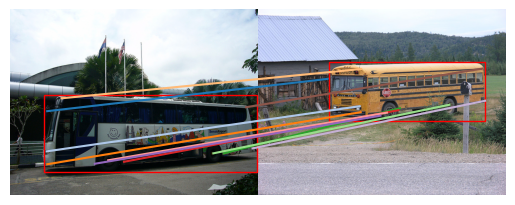

In [9]:
predicted_sample = copy.deepcopy(unprocessed_sample)
predicted_points = flip_points(predicted_points)
if rescale_data:
    predicted_points = rescale_points(predicted_points, image_size, predicted_sample['target_size'])
predicted_sample['target_points'] = predicted_points

display_image_pair(predicted_sample, show_bbox=True)

In [10]:
# calculate PCK values
target_points = unprocessed_sample['target_points']
source_points = unprocessed_sample['source_points']
target_bbox = unprocessed_sample['target_bbox']
pck_img = compute_pck_img(predicted_points, target_points, image_size, pck_threshold)
pck_bbox = compute_pck_bbox(predicted_points, target_points, target_bbox, pck_threshold)
keypoints = len(source_points)

print(f"pck_img: {pck_img / keypoints}, pck_bbox: {pck_bbox / keypoints}")

pck_img: 0.8181818181818182, pck_bbox: 0.8181818181818182
